In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = np.load("./misc/forzhiquan_npsave")

In [5]:
np.shape(data[:,:,:,3])

(4, 100, 100)

In [6]:
psi1, psi2, psi1p, psi2p = data

In [7]:
def grad(field,dir,order,N):
    """
    take derivative of a field, in a specific direction,
    with some number of points included (stencil number)
    This is a cheap-imitation of something that would use non-axis points
    https://web.media.mit.edu/~crtaylor/calculator.html
    Probably thats what they meant by seven-point stencil though, the (2,3) scheme I wrote below

    Inputs:
        field: real numpy array
        dir: axis to compute
        order: order of derivative to compute
        N: number of points to include
    """
    if (order,N) == (1,2):
        return (-np.roll(field,-1,axis=dir) + \
               np.roll(field,1,axis=dir))

    if (order,N) == (2,3):
        return (np.roll(field,-1,axis=dir) + \
               -2*np.roll(field,-1,axis=dir) + \
               np.roll(field,1,axis=dir))
    if (order,N) == (2,7):
        return (2*np.roll(field,-3,axis=dir) + \
               -27*np.roll(field,-2,axis=dir) + \
               270*np.roll(field,-1,axis=dir) + \
               -490*field + \
               270*np.roll(field,1,axis=dir) + \
               -27*np.roll(field,2,axis=dir) + \
               2*np.roll(field,3,axis=dir))/180
    else:
        print(order,N)
        raise NotImplementedError
        
def sum_gradsq_scaled(field,eta,fa,a,order=1,N=2):
    axes = len(np.shape(field))
    result = np.zeros(np.shape(field))
    for i in range(axes):
        result += grad(field,i,order,N)**2 * (a*eta/fa)**2  # H1=fa
    return result

def prime_atan(A,B,Ap,Bp):
    return ( Ap/B - A*Bp/B**2 ) / (1 + (A/B)**2)

In [8]:
def energy_density(data,eta,fa,a):
    psi1, psi2, psi1p, psi2p = data
    theta = np.arctan(psi1/psi2)
    return fa**4 / (2* eta**2) * (prime_atan(psi1,psi2,psi1p,psi2p)**2 + sum_gradsq_scaled(theta,eta,fa,a))

In [9]:
eta = 10.01
fa = 0.1
a = 0.25

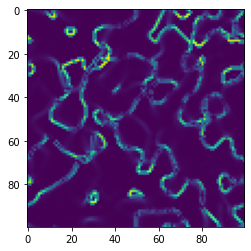

In [10]:
plt.imshow(energy_density(data[:,:,:,26],eta,fa,a))
plt.savefig("../presentation/figs/afterPQ_2dexample",format='pdf')

In [11]:
x = np.arange(0,100)
y = np.arange(0,100)
z = np.arange(0,100)

In [12]:
density = energy_density(data,eta,fa,a)

In [13]:
X, Y, Z = np.meshgrid(x, y, z)

In [14]:
norm_density = density/np.max(density)

In [15]:
colors = np.stack([np.zeros((100,100,100)),np.zeros((100,100,100)),norm_density,norm_density],axis=-1)

In [22]:
c2 = []
for x in colors.reshape((100**3,4)):
    if x[-1] > 0.002:
        c2.append(tuple(x))
    else:
        c2.append((0,0,1,0))

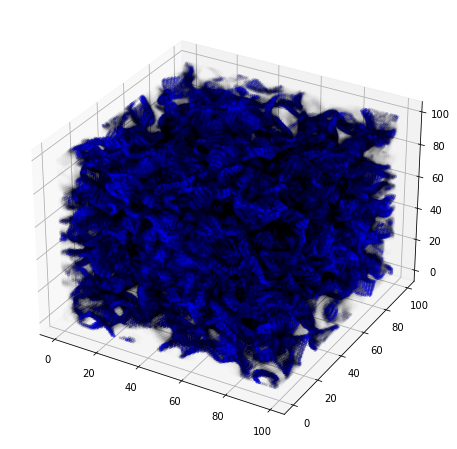

In [23]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(X, Y, Z, c=c2, marker='.',)
plt.show()

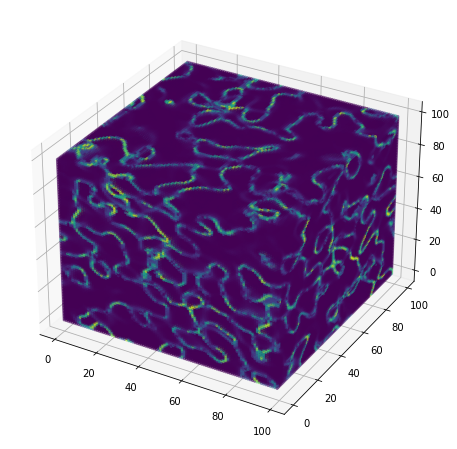

In [49]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(X, Y, Z, c=density, alpha=0.5, marker='.',)
fig.savefig("../presentation/figs/afterPQ_3dsurface.png",format='png')
plt.show()

In [35]:
import paraview
paraview.compatibility.major = 4
paraview.compatibility.minor = 0

# Now, import the modules of interest.
from paraview.simple import *

In [19]:
from pyevtk.hl import gridToVTK 

In [24]:
gridToVTK("./misc/data", X, Y, Z, pointData={"temp" : norm_density})

'/Users/zqsun/Desktop/GradMIT/SP2023/Cosmology/axion_cosmo/notebooks/misc/data.vts'

In [26]:
np.min(norm_density)

2.1087227217805278e-07

In [27]:
PQ_end = np.load("./misc/PQ_ev.npy")

In [55]:
PQ_end[:,0,10,10,10]

array([ 4.04545994, -0.36490246, -0.41799266, -0.40127168, -0.41298063,
       -0.41073375, -0.4132172 , -0.4131926 , -0.41332244, -0.41340981])

In [29]:
QCD_end = np.load("./misc/QCD_end.npy")

In [30]:
QCD_end.shape

(4, 100, 100, 100)

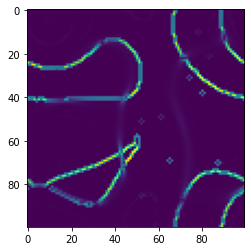

In [32]:
plt.imshow(energy_density(QCD_end[:,:,:,26],eta,fa,a))
plt.savefig("../presentation/figs/afterQCD_2dexample",format='pdf')

In [33]:
density_QCD = energy_density(QCD_end,eta,fa,a)

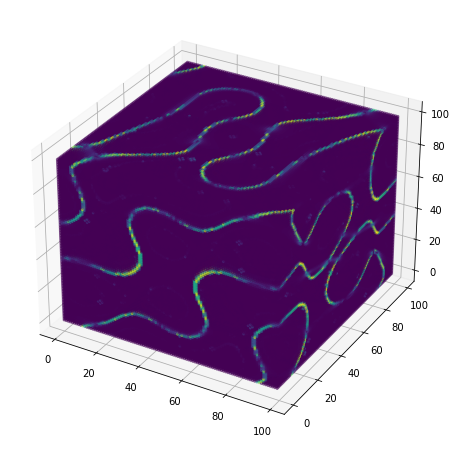

In [48]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(X, Y, Z, c=density_QCD, alpha=0.5, marker='.',)
#fig.savefig("../presentation/figs/afterQCD_3dsurface.png",format='png')
plt.show()

In [39]:
colors_QCD = np.stack([np.zeros((100,100,100)),np.zeros((100,100,100)),density_QCD,density_QCD],axis=-1)
c2_QCD = []
for x in colors_QCD.reshape((100**3,4)):
    if x[-1] > 0.002:
        c2_QCD.append([x[0],x[1],x[2],x[3]**(1/2)])
    else:
        c2_QCD.append((0,0,1,0))

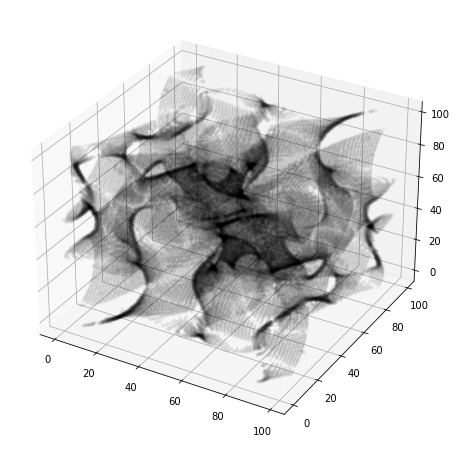

In [46]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(X, Y, Z, c=c2_QCD, marker='.')
#fig.savefig("../presentation/figs/QCD_end_walls.png",format='png')
plt.show()

In [41]:
norm_density_QCD = density_QCD/np.max(density_QCD)
gridToVTK("./misc/QCD_end", X, Y, Z, pointData={"temp" : norm_density_QCD})

'/Users/zqsun/Desktop/GradMIT/SP2023/Cosmology/axion_cosmo/notebooks/misc/QCD_end.vts'